# Catalogues of LISA-detectable sBHB inspirals and confusion backgrounds following the GWTC-3 fiducial model posterior

## Demo notebook

For examples of how to load and process the catalogues, see the `Demo.ipynb` notebook.

This notebook requires the following Python packages:

    numpy, scipy, pandas, matplotlib, pyyaml, tqdm
    
Some of the plots in the notebook require the `extrapops` simulation package:

    $ git clone git@github.com:JesusTorrado/extrapops.git
    $ cd extrapops
    $ pip install .

There is an additional notebook, `xyz.ipynb`, containing the precise code for the plots in the first of the publications below. 

## References

For details, see, and cite accordingly:

#### Individual sources:

*Stellar-mass black-hole binaries in LISA: characteristics and complementarity with current-generation interferometers*,<br>R. Buscicchio, J. Torrado, C. Caprini, G. Nardini, N. Karnesis, M. Pieroni, A. Sesana<br>
[arXiv:2410.18171 [astro-ph.HE]](https://arxiv.org/abs/2410.18171)

#### Confusion background:

*Stochastic gravitational wave background from stellar origin binary black holes in LISA*,<br>
S. Babak, C. Caprini, D. G. Figueroa, N. Karnesis, P. Marcoccia, G. Nardini, M. Pieroni, A. Ricciardone, A. Sesana, J. Torrado<br>
[JCAP 08 (2023) 034](https://iopscience.iop.org/article/10.1088/1475-7516/2023/08/034), [arXiv:2304.06368 [astro-ph.CO]](https://arxiv.org/abs/2304.06368)

## Questions and comments

Please use the [GitHub issue tracker](https://github.com/JesusTorrado/LISA_sBHB_catalogues/issues) or contact the corresponding authors of the papers above.

In [1]:
# You can skip loading and using a fraction of the catalogues, to save memory and make evaluation faster.
# Set to X to load 1/X catalogues (1 to load all catalogues)
load_one_every = 10

## Loading tables

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
from collections import ChainMap
from typing import Mapping
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14


# Paths and filenames
path_catalogues = "data/SNR_min_2_z1_LISA_SNR"
filename_catalogue_with_snr = "population_detector_frame_SNR.h5"
filename_params = "population.yaml"
filename_background = "background.txt"

def flatten_params(params_dict):
    flattened = dict(ChainMap(*list(params_dict.values())))
    for k, v in list(flattened.items()):
        if isinstance(v, Mapping):
            flattened.pop(k)
            flattened.update(v)
        if k.endswith("_range"):
            flattened.pop(k)
            k = k[:-len("_range")]
            flattened[k + "_min"] = v[0]
            flattened[k + "_max"] = v[1]
    return flattened

# Conventions
color_snr = {4: "tab:blue", 6: "tab:orange", 8: "tab:green"}

In [3]:
_cat_colname = "catalogue"
_bkg_colname = "bkg_hsq_pivot"
f_pivot_bkg = 3e-3
all_catalogues = []
all_params = []
n_actually_loaded = 0
not_found = []
no_sources = []
dirs_catalogues = os.listdir(path_catalogues)
print("Loading... (takes a few minutes)")
max_catalogue_index = max(int(i) for i in dirs_catalogues)

for i in tqdm(range(max_catalogue_index)):
    if int(1 + np.random.random() * load_one_every) % load_one_every:
        continue
    i_str = str(i)
    catalogue_dir = os.path.join(path_catalogues, i_str)
    # Read parameters
    try:
        with open(os.path.join(catalogue_dir, filename_params), "r") as paramsfile:
            params = yaml.safe_load("\n".join(paramsfile.readlines()))
        params = flatten_params(params)
        all_params.append(pd.DataFrame(params, index=[i]))
    except FileNotFoundError:
        not_found.append(i)
        continue
    # Add background -- pick a point towards the middle, and convert to pivot
    with open(os.path.join(catalogue_dir, filename_background), "r") as bkgfile:
        # saved in characteristic unitless strain-squared
        f, hsq = [float(field) for field in bkgfile.readlines()[50].split()]
        all_params[-1][_bkg_colname] = hsq * (f_pivot_bkg / f)**(-4 / 3)
    # Read catalogues
    try:
        cat = pd.read_hdf(
            os.path.join(catalogue_dir, filename_catalogue_with_snr), key="SOBBH")
        cat[_cat_colname] = i_str
    except (FileNotFoundError, KeyError):  # no SNR data
        no_sources.append(i)
        continue
    all_catalogues.append(cat)
    # Add #events with SNR
    for snr_i in [4, 6, 8]:
        all_params[-1][f"n_snr_LISA_ge_{snr_i}"] = len(cat[cat["snr_LISA"] > snr_i])
    n_actually_loaded += 1
print("Concatenating... (takes a few seconds)")
all_catalogues = pd.concat(all_catalogues, ignore_index=True)
all_params = pd.concat(all_params, ignore_index=False)
# Table of failed catalogues (not important; kept for statistical purposes)
params_no_sources = all_params[np.isnan(all_params["n_snr_LISA_ge_4"])]

print(f"Done! Loaded {n_actually_loaded} catalogues of {1 + max_catalogue_index} ({len(not_found)} not found; {len(no_sources)} had no sources)")

Loading... (takes a few minutes)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11468/11468 [00:17<00:00, 658.57it/s]


Concatenating... (takes a few seconds)
Done! Loaded 1055 catalogues of 11469 (0 not found; 76 had no sources)


## Description of the catalogue parameters table `all_params`

`all_params`: table of **population** parameters per catalogue, including for each catalogue its background amplitude and number of soruces for a single realization with realistic LISA SNR threshold 4, 6, 8.

It is useful to derive the distribution of the numbers of sources and confusion noise amplitude, and the correlations of them with population parameters, as seen below.

Description of the columns (constant where indicated, varied over GWTC-3 posterior otherwise):

Column  | Description  | Notes
--------|--------------|------
`Index` | catalogue id |
`z_min` | Minimum redshift for source generation | constant: `1e-5`
`z_max` | Maximum redshift for source generation | constant: `1`
`T_yr` | Maximum residual time to coalescence | constant: `2000` yr, Detector Frame
`z_0` | Reference redshift for the rate normalization | constant: `0`
`R_0` | Merger rate value at `z=z_0` | in $\mathrm{Gpc}^{⁻3} \mathrm{yr}^{⁻1}$
`merger_rate_model` | Model for the merger rate | constant: `"madau"`, see eq. () in XXXX
`d` | Low-redshift power-law index, $\kappa$ in Eq. (2.3) in [1] |
`r` | High-redshift power-law index, see Eq. (2.3) in [1] | constant: `-2.9`
`z_peak` | Redshift of the peak in merger rate, see Eq. (2.3) in [1] | constant: `1.86`
`z_perdecade` | Precision parameter for the merger rate sampling | constant: `500`
`m_min` | Minimum mass for source generation | in $M_\odot$, Source Frame
`m_max` | Maximum mass for source generation | in $M_\odot$, Source Frame
`delta_m` | Tapering-off mass parameter, $\delta_\mathrm{min}$ from Eq. (A.5) in [1] | in $M_\odot$, Source Frame
`lambda_peak` | Mixture parameter for $m_1$ dist, see Eq. (A.3) in [1] |
`alpha` | Index of power-law component for $m_1$, see Eq. (A.3) in [1] |
`mu_m` | Mean of the Gaussian component for $m_1$, see Eq. (A.3) in [1] | in $M_\odot$, Source Frame
`sigma_m` | Std of the Gaussian component for $m_1$, see Eq. (A.3) in [1] | in $M_\odot$, Source Frame
`beta_q` | Index of power-law dist for $q=m_1/m_1$ see Eq. (A.6) in [1] |
`m_perdecade` | Precision parameter for the mass dist. sampling | constant: `400`
`expected_a` | Mean of the spin amplitude Beta pdf, see Eq. (A.9) in [1] |
`var_a` | Std of the spin amplitude Beta pdf, see Eq. (A.9) in [1] |
`zeta_spin` | Mixture parameter for the spin tilts dist., see Eq. (A.10) in [1] |
`sigma_t` | Std of Gaussian component of spin tilts dist., see Eq. (A.10) in [1] |
`H_0` | Hubble parameter at $z=0$ | constant: $67.9\,\mathrm{km}\,\mathrm{s}^{-1} \mathrm{Mpc}^{-1}$ from Planck 2015)
`Omega_m` | Density parameter for matter at $z=0$ | constant: `67.9` from Planck 2015
`Omega_l` | Density parameter for dark energy at $z=0$ | constant: `0.7` from Planck 2015
`Omega_r` | Density parameter for radiation $z=0$ | constant: `0` from Planck 2015
`Omega_k` | Density parameter for curvature at $z=0$ | constant: `0` from Planck 2015
`bkg_hsq_pivot` | Confusion background amplitude at $f=3\cdot10^{-3}$ | unitless characteristic strain squared
`n_snr_LISA_ge_4` | Number of sources with realistic LISA SNR $\ge 4$ for a single realization
`n_snr_LISA_ge_6` | Number of sources with realistic LISA SNR $\ge 6$ for a single realization
`n_snr_LISA_ge_8` | Number of sources with realistic LISA SNR $\ge 8$ for a single realization

[1] https://arxiv.org/abs/2304.06368

### Distribution of background amplitudes

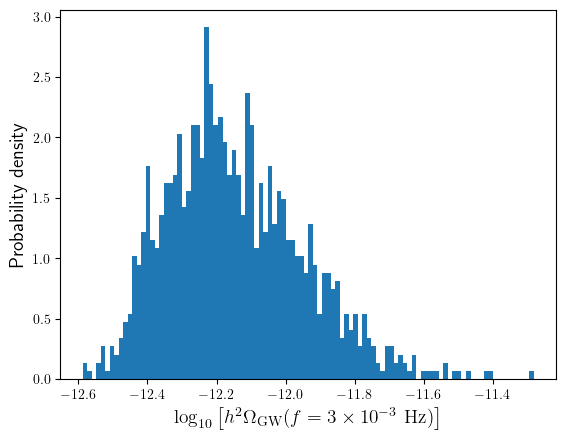

In [4]:
# Posterior distribution of confusion noise log-amplitudes (char. strain squared or h2Omega units):

h2Omega_units = True

values = all_params[_bkg_colname].copy()

if h2Omega_units:
    H_to_invs = 1e3 / 3.0857e22  # Conversion factor for H from km/s/Mpc to 1/s
    values *= 2 * np.pi**2 / 3 / (100 * H_to_invs)**2 * np.array(f_pivot_bkg)**2

plt.figure()
plt.hist(np.log10(values), bins=100, density=True)
plt.xlabel(r"$\log_{10}\left[h^2\Omega_\mathrm{GW}(f=3\times10^{-3}\ \mathrm{Hz})\right]$")
plt.ylabel("Probability density")
plt.show()

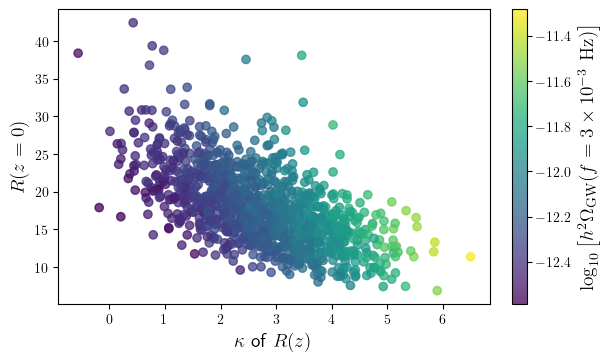

In [5]:
# 2d scatter plots of parameters vs background amplitude
# NB: reuses units (char strain sq or h2Omega) from prev cell

p_1, p_1_label = "d", r"$\kappa$ of $R(z)$"
p_2, p_2_label = "R_0", r"$R(z=0)$"

plt.figure(figsize=(6, 3.5), layout="constrained")
sc = plt.scatter(all_params[p_1], all_params[p_2], c=np.log10(values), marker="o", alpha=0.75, rasterized=True)
plt.xlabel(p_1_label)
plt.ylabel(p_2_label)
cb = plt.colorbar(sc)
cb.set_label(r"$\log_{10}\left[h^2\Omega_\mathrm{GW}(f=3\times10^{-3}\ \mathrm{Hz})\right]$")
plt.show()

### Distribution of #events for SNR>8,6,4: plot and table

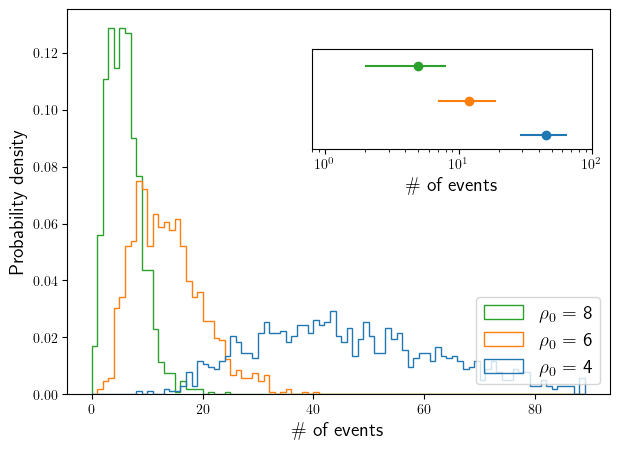

   frac_zero  P_05  P_16  P_50   P_84  P_95
4   0.000000  21.7  29.0  45.0  65.36  80.0
6   0.000000   5.0   7.0  12.0  19.00  25.0
8   0.017062   1.0   2.0   5.0   8.00  11.0


In [6]:
table_percentiles = pd.DataFrame(index=list(color_snr))

get_counts_fast = lambda snr: np.sort((lambda x: x[~np.isnan(x)])(all_params[f"n_snr_LISA_ge_{snr}"])).astype(int)

counts8 = get_counts_fast(8)
counts6 = get_counts_fast(6)
counts4 = get_counts_fast(4)

snr_label = r"$\rho_0=$"
kwargs = {"histtype": "step", "density": True}
bins = range(int(max(counts4) * 0.75))
snr_counts = {8: counts8, 6: counts6, 4: counts4}

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()
width, height = [0.4, 0.2]
left, bottom = [1 - width - 0.125, 0.6]
inset = fig.add_axes([left, bottom, width, height])
percts = [5, 16, 50, 84, 95]
for i, (snr, counts) in enumerate(snr_counts.items()):
    ax.hist(counts, bins=bins, label=f"{snr_label} {snr}", color=color_snr[snr], **kwargs)
    l90, l1s, median, u1s, u90 = np.percentile(counts, percts)
    n_zero_counts = dict(zip(*np.unique(counts, return_counts=True))).get(0, 0)
    table_percentiles.loc[snr, "frac_zero"] = n_zero_counts / len(counts)
    table_percentiles.loc[snr, [f"P_{p:02d}" for p in percts]] = l90, l1s, median, u1s, u90
    inset.errorbar(median, snr, xerr=[[-l1s + median], [u1s - median]], fmt="o", c=color_snr[snr])

ax.legend(loc="lower right")
ax.set_xlabel("\# of events")
ax.set_ylabel("Probability density")
inset.set_yticks([])
inset.set_xscale("log")
inset.set_xlim(8e-1, 100)
inset.set_ylim(0.8 * min(snr_counts), 1.125 * max(snr_counts))
inset.set_xlabel(ax.get_xlabel())
plt.show()
plt.close()

# Print table with fraction of zero counts and percentiles for # events
print(table_percentiles)

### Correlations between population parameters, #events, and background amplitude 

In [7]:
# Remove constant parameter columns
all_params_varying = all_params[all_params.columns[all_params.nunique() > 1]].copy()

# Add merger rate at z=0.2 to check that the correlation with #sources disappears
z_pivot = 0.2
position_R_0 = list(all_params_varying.columns).index("R_0") + 1
all_params_varying.insert(loc=position_R_0, column="R_0p2", value=all_params["R_0"] * (1 + z_pivot)**all_params["d"])

# Plot correlations
columns_events_and_bkg = ["n_snr_LISA_ge_4", "n_snr_LISA_ge_6", "n_snr_LISA_ge_8", _bkg_colname]
i_rows = [c for c in all_params_varying.columns if c in columns_events_and_bkg]
all_params_varying.select_dtypes(['number']).corr()[i_rows].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

,bkg_hsq_pivot,n_snr_LISA_ge_4,n_snr_LISA_ge_6,n_snr_LISA_ge_8
expected_a,0.16,-0.19,-0.15,-0.12
var_a,-0.06,0.01,0.00,0.00
zeta_spin,-0.05,0.09,0.08,0.06
sigma_t,0.08,-0.03,-0.02,0.00
delta_m,-0.01,0.00,0.02,0.01
alpha,0.40,-0.52,-0.44,-0.38
lambda_peak,-0.30,0.29,0.26,0.24
mu_m,-0.15,0.16,0.11,0.08
sigma_m,-0.02,-0.01,-0.01,0.04
beta_q,-0.33,0.30,0.27,0.20


In [8]:
# Options for parameter correlation plots

# Which SNR threshold to use
use_snr = 8  # 4, 6, 8

# Values to plot, by default the median, 1-sigma and 2-sigma upper percentiles
# The cast to int is for the legend labels
counts = [int(c) for c in table_percentiles.loc[use_snr][["P_50", "P_84", "P_95"]]]

# Colours for each category
counts_colors = [mpl.colors.CSS4_COLORS["teal"], mpl.colors.CSS4_COLORS["orange"], mpl.colors.CSS4_COLORS["purple"]]

# Checks and settings
assert use_snr in [4, 6, 8], "Only [4,6,8] possible."

def label_of_count(i_count, counts):
    label = r"N_\mathrm{det}"
    if i_count == 0:
        return "$" + label + r"< " + str(counts[i_count]) + "$"
    elif i_count != len(counts) - 1:
        return "$" + str(counts[i_count - 1]) + r"< " + label + r"< " + str(counts[i_count]) + "$"
    else:
        return "$" + label + r"> " + str(counts[i_count - 1]) + "$"

n_snrs = all_params[f"n_snr_LISA_ge_{use_snr}"].to_numpy(int)
bin_edges = [0] + list(counts)
i_each = [np.argwhere(np.logical_and(bin_edges[j] < n_snrs, n_snrs < bin_edges[j + 1]))
           for j in range(len(bin_edges) - 1)]

/home/jesus/.local/lib/python3.10/site-packages/pandas/core/base.py:662: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(values, dtype=dtype)


In [9]:
# Plot correlation to merger rate

# Plot settings
z_max_plot = 1
delta_zs = 0.05

from extrapops.redshifts import R

zs = np.arange(all_params.iloc[0]["z_min"], z_max_plot + (z_max_plot - all_params.iloc[0]["z_min"]) / delta_zs, delta_zs)

const_args = {"model": all_params.iloc[0]["merger_rate_model"],
              "params": {"z_0": all_params.iloc[0]["z_0"],
                         "z_peak": all_params.iloc[0]["z_peak"],
                         "r": all_params.iloc[0]["r"]}}
R_0s = all_params["R_0"].to_numpy(float)
ds = all_params["d"].to_numpy(float)

percts_bins = {c : [] for c in counts}

# Not vectorized in z: slower but less memory consuming.
for z in tqdm(zs, total=len(zs)):
    Rs = []
    for i, (R_0, d, n_snr) in enumerate(zip(R_0s, ds, n_snrs)):
        const_args["params"].update({"R_0": R_0, "d": d})
        Rs.append(R(z, **const_args))
    Rs = np.array(Rs)
    for i_c, c in enumerate(percts_bins):
        percts_bins[c].append([np.percentile(Rs[i_each[i_c]], [5, 25, 50, 75, 95])])
for c in percts_bins:
    percts_bins[c] = np.concatenate(percts_bins[c])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:05<00:00, 82.15it/s]


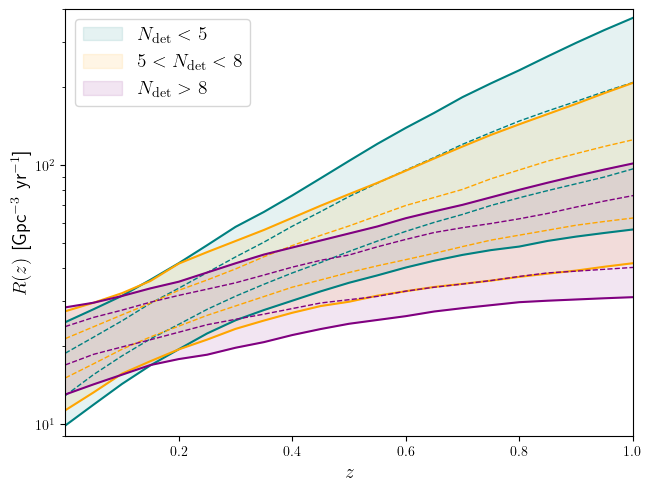

In [10]:
plt.figure(layout="constrained")
for i_count, (count, colour) in enumerate(zip(counts, counts_colors)):
    label = label_of_count(i_count, counts)
    plt.fill_between(zs, percts_bins[count][:, 0], percts_bins[count][:, 4], color=colour, alpha=0.1, label=label)
    plt.plot(zs, percts_bins[count][:, 0], lw=1.5, ls="-", c=colour, alpha=1)
    plt.plot(zs, percts_bins[count][:, 4], lw=1.5, ls="-", c=colour, alpha=1)
    plt.plot(zs, percts_bins[count][:, 1], lw=1, ls="--", c=colour, alpha=1)
    plt.plot(zs, percts_bins[count][:, 3], lw=1, ls="--", c=colour, alpha=1)
plt.yscale("log")
plt.legend(loc="upper left")
plt.xlabel("$z$")
plt.xlim(zs[0], z_max_plot)
plt.ylim(9e0, 4e2)
plt.ylabel(r"$R(z)$ [Gpc$^{-3}$ yr$^{-1}$]")
plt.show()

In [11]:
# Plot correlation to larger mass

# Plot settings
delta_mrange = 1

from extrapops.mass import pdf_m1

m_mins = all_params["m_min"].to_numpy(float)
m_maxs = all_params["m_max"].to_numpy(float)
m_ranges = np.array(list(zip(m_mins, m_maxs)))
lambda_peaks = all_params["lambda_peak"].to_numpy(float)
alphas = all_params["alpha"].to_numpy(float)
mu_ms = all_params["mu_m"].to_numpy(float)
sigma_ms = all_params["sigma_m"].to_numpy(float)
delta_ms = all_params["delta_m"].to_numpy(float)

m_mmin, m_mmax = min(m_mins), max(m_maxs)
ms = np.arange(m_mmin, m_mmax + (m_mmax - m_mmin) / delta_mrange, delta_mrange)

# Here we invert the loop w.r.t. the rate, because we need to do a normalization integral
# every time we compute pdf_m1 for different parameters.
# So we need to store ALL values until the end: which imposes a memory limit in the number of bins.
# But adding more bins won't make it slower: will just need more memory

# This will prob take ~15min / n_threads

pdf_m1_values = np.empty(shape=(len(all_params), len(ms)), dtype=float)

from multiprocessing import Pool

n_threads = 6

def pdf_m1_with_args(args):
    return pdf_m1(ms, **args)

with Pool(n_threads) as pool:
    pdf_m1_values = list(tqdm(pool.imap(
        pdf_m1_with_args,
        [{"m_range": m_range, "lambda_peak": lambda_peak, "alpha": alpha,
          "mu_m": mu_m, "sigma_m": sigma_m, "delta_m": delta_m}
         for (m_range, lambda_peak, alpha, mu_m, sigma_m, delta_m)
         in zip(m_ranges, lambda_peaks, alphas, mu_ms, sigma_ms, delta_ms)]
    ), total=len(m_ranges)))
pdf_m1_values = np.array(pdf_m1_values)

percts_bins_m1 = {c : [] for c in counts}

for i_c, c in enumerate(percts_bins):
    percts_bins_m1[c] = np.percentile(pdf_m1_values[i_each[i_c].T[0]], [5, 25, 50, 75, 95], axis=0).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1131/1131 [00:29<00:00, 38.27it/s]


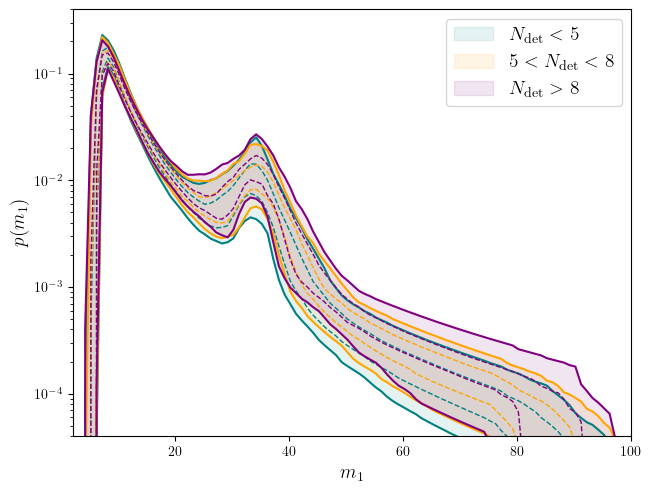

In [12]:
plt.figure(layout="constrained")
for i_count, (count, colour) in enumerate(zip(counts, counts_colors)):
    label = label_of_count(i_count, counts)
    plt.fill_between(ms, percts_bins_m1[count][:, 0], percts_bins_m1[count][:, 4], color=colour, alpha=0.1, label=label)
    plt.plot(ms, percts_bins_m1[count][:, 0], lw=1.5, ls="-", c=colour, alpha=1)
    plt.plot(ms, percts_bins_m1[count][:, 4], lw=1.5, ls="-", c=colour, alpha=1)
    plt.plot(ms, percts_bins_m1[count][:, 1], lw=1, ls="--", c=colour, alpha=1)
    plt.plot(ms, percts_bins_m1[count][:, 3], lw=1, ls="--", c=colour, alpha=1)
plt.yscale("log")
plt.legend(loc="upper right")
plt.xlabel("$m_1$")
plt.xlim(2, 100)
plt.ylim(4e-5, 4e-1)
plt.ylabel(r"$p(m_1)$")
plt.show()

## Description of the table of loud events per catalogue `all_catalogues`

`all_catalogues`: table of **source parameters** per events, containing events from all catalogues.

It includes all sources generated using the process described in the accompanying publication, which contain, but are not limited to, the realistic SNR thresholds $\rho_0=4, 6, 8$. For convenience, we prepare the following tables, including only above/between thresholds:

In [13]:
snr8_events = all_catalogues[all_catalogues["snr_LISA"] > 8]
snr6_events = all_catalogues[all_catalogues["snr_LISA"] > 6]
snr4_events = all_catalogues[all_catalogues["snr_LISA"] > 4]

snr6to8_events = all_catalogues[np.logical_and(all_catalogues["snr_LISA"] < 8, all_catalogues["snr_LISA"] > 6)]
snr4to6_events = all_catalogues[np.logical_and(all_catalogues["snr_LISA"] < 6, all_catalogues["snr_LISA"] > 4)]

### Description of the columns in `all_catalogues`, `snr[X]_events` and `snr[X]to[Y]_events`

These tables follow the conventions of `LISACode` regarding names, units and frame of reference (detector frame where relevant).

Initial and Final frequencies are clipped to the LISA bandwidth, $3\cdot10^{-5}, 0.5)\,\mathrm{Hz}$.

Column  | Description
--------|------------
`Index` | source id (not relevant)
`Redshift` | Redshift of the source
`Distance` | Luminosity distance $d_\mathrm{L}$, in $\mathrm{Gpc}$
`Mass1` | Mass of the larger component, `m_1` in Eq. (A.3) in [1], in $M_\odot$, Detector Frame
`Mass2` | Mass of the lighter component, `m_2` in Eq. (A.3) in [1], in $M_\odot$, Detector Frame
`ChirpMass` | Chirp mass of the binary, in $M_\odot$, Detector Frame
`Spin1` | Spin aplitude of the larger component, $a_1$ in Eq. (A.8) in [1]
`Spin2` | Spin aplitude of the lighter component, $a_2$ in Eq. (A.8) in [1]
`AzimuthalAngleOfSpin1` | Spin tilt of the larger component, $\phi_1$ in Eq. (A.9) in [1], in $\mathrm{rad}$
`AzimuthalAngleOfSpin2` | Spin tilt of the lighter component, $\phi_2$ in Eq. (A.9) in [1], in $\mathrm{rad}$
`CoalTime` | Residual time to coalescence $\tau_c$ in $\mathrm{yr}$, Detector Frame
`InitialFrequency` | Source emission frequency at the start of the LISA mission, in $\mathrm{Hz}$, Detector Frame
`FinalFrequency` | Source emission frequency at the end of the LISA mission, in $\mathrm{Hz}$, Detector Frame
`InBandTime` | Time spent emitting in the LISA band, in $\mathrm{yr}$, Detector Frame
`InitialPhase` | Phase at the start of the LISA mission, in $\mathrm{rad}$
`Polarization` | Polarization emisison angle, in $\mathrm{rad}$
`EclipticLatitude` | Ecliptic latitude, in $\mathrm{rad}$
`EclipticLongitude` | Ecliptic longitude, in $\mathrm{rad}$
`Inclination` | Inclination, in $\mathrm{rad}$
`snr_avg_inclination` | Approximate LISA SNR of source averaged over all possible inclinations, see [2]
`snr_max_inclination` | Approximate LISA SNR of source assuming optimal inclination, $\cos\iota = 1$, see [2]
`snr_LISA` | Realistic LISA SNR of source computed with the code described in [3]
`catalogue` | id of catalogue to which the source belongs, see row with index `id` in `all_params` table

[1] https://arxiv.org/abs/2304.06368
[2] https://arxiv.org/pdf/2108.01167, Section 7.1.1
[3] https://arxiv.org/abs/2103.14598

### Transforming a column to source frame

To do that, use `Redshift` column of the same table, e.g.

    snr4_ChirpMassSourceFrame = snr4_events["ChirpMass"] / (1 + snr4_events["Redshift"])

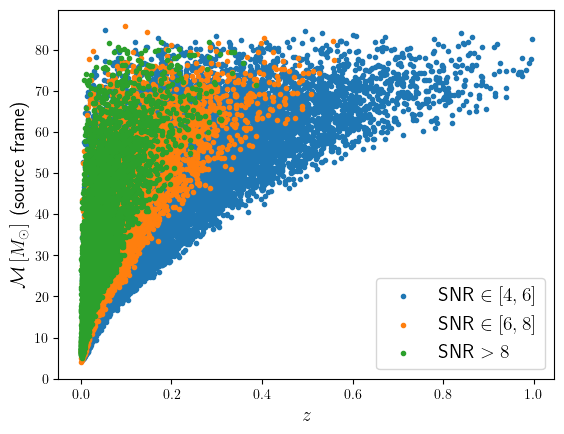

In [14]:
# ChirpMass (source frame)/Redshift distribution per SNR bins

plt.figure()
plt.scatter(snr4to6_events["Redshift"],
            snr4to6_events["ChirpMass"] / (1 + snr4to6_events["Redshift"]),
            marker=".", color=color_snr[4], label=r"SNR $\in [4, 6]$")
plt.scatter(snr6to8_events["Redshift"],
            snr6to8_events["ChirpMass"] / (1 + snr6to8_events["Redshift"]),
            marker=".", color=color_snr[6], label=r"SNR $\in [6, 8]$")
plt.scatter(snr8_events["Redshift"],
            snr8_events["ChirpMass"] / (1 + snr8_events["Redshift"]),
            marker=".", color=color_snr[8], label=r"SNR $> 8$")

plt.xlabel(r"$z$")
plt.ylabel(r"$\mathcal{M}\,[M_\odot]$ (source frame)")
plt.legend(loc="lower right")
plt.show()
plt.close()

# NB: the clip at z>1 for SNR threshold 4 leaves out a negligible amount of sources.

Events in population #9653 (in detector frame)
         Redshift  AzimuthalAngleOfSpin1  AzimuthalAngleOfSpin2    CoalTime  \
1279901  0.008531               2.666023               2.140336  192.240145   
1280018  0.021965               1.207366               1.557570   22.675173   
1280121  0.026895               1.757176               0.819788   39.128098   
1280375  0.002760               1.071990               0.364906  634.745732   
1280604  0.074905               0.774036               0.451422    4.335616   
1280710  0.091531               0.856257               1.688937    6.687516   
1280815  0.050568               2.921445               1.465954   10.124764   
1281077  0.026041               1.016119               0.360057    7.149575   

         Distance  EclipticLatitude  EclipticLongitude  InBandTime  \
1279901  0.037916          0.233321           3.800714         4.0   
1280018  0.098619         -0.496256           2.578507         4.0   
1280121  0.121201         -0.89

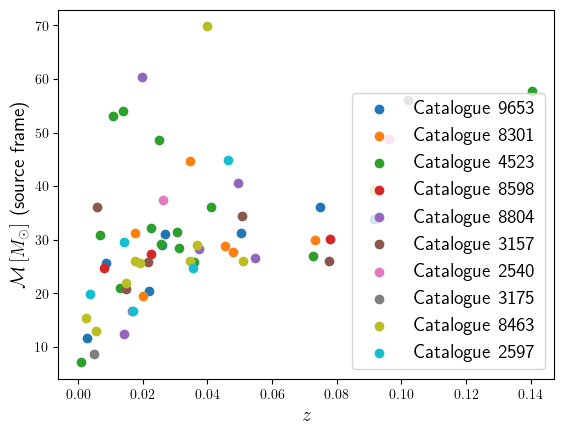

In [15]:
# Print and plot sources from a few posterior samples from the set of catalogues
from random import shuffle

n_draws = 5
table_to_plot = snr8_events

cataux = list(all_params[np.logical_not(np.isnan(all_params["n_snr_LISA_ge_4"]))].index)
shuffle(cataux)
for i in cataux[:10]:
    i_str = str(i)
    subtable = table_to_plot[table_to_plot[_cat_colname] == i_str]
    plt.scatter(subtable["Redshift"], subtable["ChirpMass"] / (1 + subtable["Redshift"]), label=f"Catalogue {i_str}")
    print(f"Events in population #{i_str} (in detector frame)")
    print(subtable)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mathcal{M}\,[M_\odot]$ (source frame)")
plt.legend()
plt.show()
plt.close()

### Stats and plots for multi-band sources

As in the accompanying paper, we will focus both on sources mergin in less that $15\,\mathrm{yr}$ (detector frame) and before the end of the nominal $4\,\mathrm{yr}$ LISA mission.

In [16]:
# Percentiles of source merging before the end of the nominal mission (tauc<4yr),
# considered multiband (tauc_15yr)

def get_counts_tauc_ge_le(table, ge_tauc=0, le_tauc=np.inf):
    counts = list(table[_cat_colname][table["CoalTime"] > ge_tauc][table["CoalTime"] < le_tauc].value_counts().to_numpy(int))
    n_non_failing = len(get_counts_fast(8))  # or any SNR
    zeros_missing = n_non_failing - len(counts)
    if zeros_missing:
        counts = [0] * zeros_missing + list(counts)
    return counts

tau_c_end_det = 4
tau_c_multi_det = 15
percentiles = [5, 16, 50, 84, 95]

for (snr, events) in {8: snr8_events, 6: snr6_events, 4: snr4_events}.items():
    for tc in [4, 15]:
        counts_tauc = get_counts_tauc_ge_le(events, 0, tc)
        n_zeros = len(counts_tauc) - len(np.nonzero(counts_tauc)[0])
        # Fraction of *catalogues* with 0 sources
        table_percentiles.loc[snr, f"frac_zero_le{tc}"] = n_zeros / len(counts_tauc)
        # Fraction of *sources* with tauc smaller than given
        table_percentiles.loc[snr, f"frac_src_le{tc}"] = len(events[events["CoalTime"] < tc]) / len(events)
        # Percentiles of sources
        table_percentiles.loc[snr, [f"P_{p:02d}_le{tc}" for p in percts]] = np.percentile(counts_tauc, percts)

table_percentiles

,frac_zero,P_05,P_16,P_50,P_84,P_95,frac_zero_le4,frac_src_le4,P_05_le4,P_16_le4,P_50_le4,P_84_le4,P_95_le4,frac_zero_le15,frac_src_le15,P_05_le15,P_16_le15,P_50_le15,P_84_le15,P_95_le15
4,0.000000,21.7,29.0,45.0,65.36,80.0,0.030332,0.102423,1.0,2.0,4.0,8.0,10.0,0.000000,0.367882,7.0,10.0,17.0,25.0,30.0
6,0.000000,5.0,7.0,12.0,19.00,25.0,0.341232,0.088573,0.0,0.0,1.0,2.0,3.0,0.026540,0.343526,1.0,2.0,4.0,7.0,10.0
8,0.017062,1.0,2.0,5.0,8.00,11.0,0.647393,0.085545,0.0,0.0,0.0,1.0,2.0,0.199052,0.331878,0.0,0.0,1.0,3.0,5.0


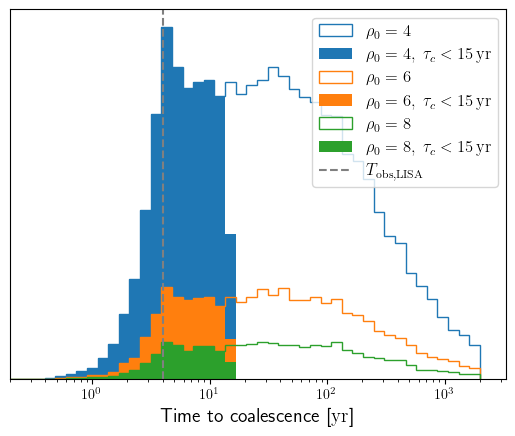

In [17]:
# Time to coalescence histrogram -- source frame or det frame (see bool below)

src_frame = False
log_scale = True
highlight_tauc_le15 = True

# Distribution of CoalTime for SNR>8
plt.figure()
for (snr, events) in {4: snr4_events, 6: snr6_events, 8: snr8_events}.items():
    times = events["CoalTime"] * (1 + (events["CoalTime"] if src_frame else 0))
    bins = np.logspace(min(np.log10(times)), max(np.log10(times))) if log_scale else 1000
    plt.hist(times, bins, density=False, histtype="step", label=f"$\\rho_0={snr}$", edgecolor=color_snr[snr])
    if highlight_tauc_le15 and not src_frame and log_scale:
        plt.hist(times[times < 15], bins, density=False,
                 label=f"$\\rho_0={snr}$" + r"$,\;\tau_c<15\,\mathrm{yr}$", color=color_snr[snr])
if log_scale:
    plt.xscale("log")
    plt.xlim(2e-1, None)
else:
    plt.xlim(0, 100)
plt.xlabel("Time to coalescence [$\mathrm{yr}$]" + ("(source frame)" if src_frame else ""))
if not src_frame:
    plt.axvline(4, ls="--", c="0.5", label=r"$T_\mathrm{obs,LISA}$")
plt.gca().set(yticklabels=[])
plt.gca().tick_params(left=False)
plt.legend(loc="upper right", fontsize=12)
plt.show()
plt.close()